# Analytical Approximation to Gambit's cMSSM LHC likelihood

Synthetic data from simple expressions are useful in exploring different machine learning algorithms, but for the lessons we learn to be applicable to the real problem the synthetic data must capture the salient features of the real data.
In this notebook we try to define some simple analytical expressions that capture the main features of Gambit's cMSSM LHC likelhood by looking at the real data.
Obviously what constitutes the "main features" is a judgement question.

We begin by importing the cMSSM data. For more description of this data we refer to the dedicated notebook.

TODO: This should be a function defined elsewhere that loads this data, in order to avoid code replication.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import h5py
import pandas as pd

# Nicer labels
def label(k):
    l = k.split('::')[-1]
    if l == 'calc_LHC_LogLike':
        l = 'lnL'
    return l

df = pd.DataFrame()
with h5py.File('../CMSSM_subset.hdf5', 'r') as h5:
    for k in h5.keys():
        df[label(k)] = h5[k]

params = ['A0', 'M0', 'M12', 'TanBeta']
        
df.describe()

,A0,M0,M12,SignMu,TanBeta,lnL
count,7.275717e+06,7.275717e+06,7.275717e+06,7.275717e+06,7.275717e+06,7.275717e+06
mean,1.660540e+03,7.328986e+03,2.589160e+03,-1.641607e-01,3.206345e+01,-8.756418e-01
std,5.669253e+03,2.558519e+03,8.633211e+02,9.864337e-01,1.397247e+01,3.800616e+00
min,-1.000000e+04,2.437319e+02,4.374371e+02,-1.000000e+00,3.895791e+00,-3.102569e+02
25%,-1.089608e+02,7.032418e+03,2.155966e+03,-1.000000e+00,1.868139e+01,-0.000000e+00
50%,2.967025e+03,8.357059e+03,2.910376e+03,-1.000000e+00,3.731426e+01,-0.000000e+00
75%,6.212657e+03,8.987426e+03,3.185098e+03,1.000000e+00,4.360667e+01,-0.000000e+00
max,9.999976e+03,9.999995e+03,6.142120e+03,1.000000e+00,5.605191e+01,3.088628e+00


## Dimension Reduction

The cMSSM have five parameters. This is hard to visualise, but it is crucial that our synthetic examples to be easily visualisable! This means reducing the information to one or two dimensions.

This could be done by PCAing, or some other dimension reduction algorithm, but it is somewhat useful to keep the physical dimensions for interpretation. We therefor instead summerise by binning in the dimension of interest and finding the minimum, maximum and mean of the likelihood in each bin. 

In [ ]:
import scipy.stats as stats
from scipy.interpolate import PchipInterpolator

class OneDimBinnedSummary:
    def __init__(self, x, y, bins=60):
        r = stats.binned_statistic(x, y, np.max, bins)
        self.max_values = r.statistic
        
        r = stats.binned_statistic(x, y, np.min, bins)
        self.min_values = r.statistic
        
        r = stats.binned_statistic(x, y, np.mean, bins)
        self.mean_values = r.statistic
        
        self.bin_centers = r.bin_edges[:-1] + np.diff(r.bin_edges)/2
        
        self.max  = PchipInterpolator(self.bin_centers, self.max_values)
        self.min  = PchipInterpolator(self.bin_centers, self.min_values)       
        self.mean = PchipInterpolator(self.bin_centers, self.mean_values)

sum1D = {p : OneDimBinnedSummary(df[p], df['lnL']) for p in params}

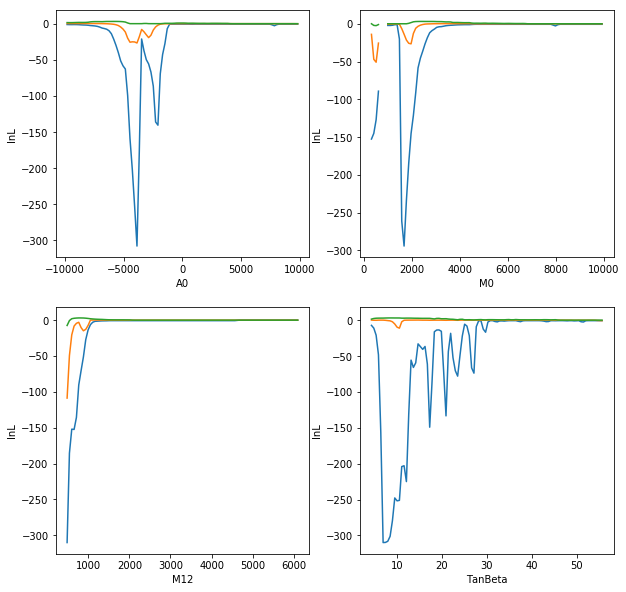

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,10))

for p, ax in zip(sum1D, axes.flatten()):
    x = np.linspace(sum1D[p].bin_centers[0], sum1D[p].bin_centers[-1], 100)

    ax.plot(x, sum1D[p].min(x))
    ax.plot(x, sum1D[p].mean(x))
    ax.plot(x, sum1D[p].max(x))
    
    ax.set_xlabel(p)
    ax.set_ylabel('lnL')

To connect to the statistical interpretation, the maximum line is the profile likelihood, while the mean is (extremely) roughly indicative of the posterior.

We will however use the minimum as that exhibits the most extreme behaviour.

## Analytic approximation for M12

M12 behaves fairly simple, and we model it with some polynomials.

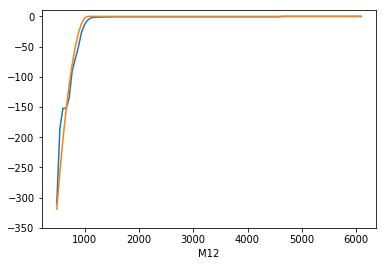

In [ ]:
p = 'M12'
x = np.linspace(sum1D[p].bin_centers[0], sum1D[p].bin_centers[-1], 100)
y = sum1D[p].min

def m12_synthetic(x):
    r = np.zeros(shape=x.shape)
    cutoff = x < 1050
    r[cutoff] = -(x[cutoff]-1050)**2/1000
    return r

plt.plot(x, y(x))
plt.plot(x, m12_synthetic(x))
plt.xlabel(p)
plt.ylim(-350, 10);

## Analytic approximation for TanBeta

TanBeta behaves comparatively complicated. Four distinct regions including a wave pattern. The approximation is consequently not as good as for M12, but do remember that we only want to capture the overall behaviour.

(-350, 10)

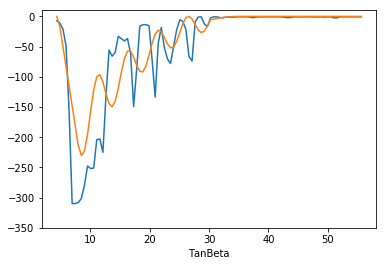

In [ ]:
p = 'TanBeta'
x = np.linspace(sum1D[p].bin_centers[0], sum1D[p].bin_centers[-1], 100)
y = sum1D[p].min

def TanBeta_synthetic(x):
    r = np.zeros(shape=x.shape)
    
    cutoff = x < 35
    r[cutoff] = -(x[cutoff]-35)**2/4
    
    cutoff = x < 30
    r[cutoff] += (500/x[cutoff])*np.sin(x[cutoff]/0.8)

    cutoff = x < 7
    
    #not_cutoff = np.logical_not(cutoff)
    #y2, x2 = r[not_cutoff][1], x[not_cutoff][1]
    #y1, x1 = r[not_cutoff][0], x[not_cutoff][0]
    #k = (y2-y1)/(x2-x1)
    #m = y1 - k*x1
    #print(k, m)
    
    k = -63
    m = 288
    
    r[cutoff] = k*x[cutoff]+m
    
    r[r>0] = 0
    return r

plt.plot(x, y(x))
plt.plot(x, TanBeta_synthetic(x))
plt.xlabel(p)
plt.ylim(-350, 10);

## 2D analytical approximation for M12 and TanBeta

The behaviour of M12 and TanBeta is fairly independent, as seen in plot below. We can therefor model it as the product of the 1D approximations defined above.

In [ ]:
mask_nan = lambda x: np.ma.masked_where(np.isnan(x), x)

x = 'M12'
y = 'TanBeta'

r = stats.binned_statistic_2d(df[x], df[y], df['lnL'], np.min, bins=50)

XX, YY = np.meshgrid(r.x_edge, r.y_edge)

def m12_TanBeta_synthetic(m12, tanbeta):
    z = -m12_synthetic(m12)*TanBeta_synthetic(tanbeta)
    return -310/z.min() * z

synth = m12_TanBeta_synthetic(XX.flatten(), YY.flatten()).reshape(XX.shape)
real = mask_nan(r.statistic).T

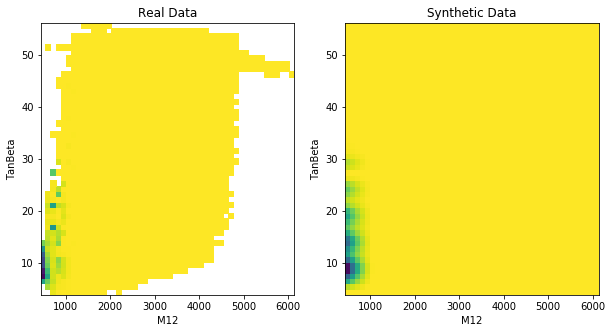

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

for ax, label, ZZ in zip(axes, ['Real Data', 'Synthetic Data'], [real, synth]):
    ax.pcolormesh(XX, YY, ZZ, vmin=-320, vmax=0)
    ax.set_title(label)
    ax.set_xlabel(x)
    ax.set_ylabel(y)